In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# Patent Phrase Matching with DeBERTa

This notebook implements a solution for the US Patent Phrase to Phrase Matching competition using DeBERTa-v3-small model. The goal is to predict similarity scores between patent phrase pairs.

In [2]:
# %pip install kaggle
import kaggle

## Setup Kaggle Environment

Setting up Kaggle credentials and API access for downloading competition data. We create a credentials file and set appropriate permissions.

In [3]:
creds = '{"username":"mohammedadilsiraju","key":"572884063344e3ecff7b5e73ace34c3c"}'

In [4]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
# Download the competition data using Python API
path = Path('data')
if not iskaggle and not path.exists():
    import zipfile
    kaggle.api.competition_download_cli('us-patent-phrase-to-phrase-matching')
    zipfile.ZipFile('us-patent-phrase-to-phrase-matching.zip').extractall(path)

## Import and EDA

In [6]:
# %pip install -q datasets

In [7]:
%ls {path}

sample_submission.csv  test.csv  train.csv


In [8]:
import pandas as pd
df = pd.read_csv(path/'train.csv')

## Data Loading and Initial EDA

Loading the training data and performing initial exploratory data analysis to understand the structure and content of our dataset.

In [9]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [10]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [11]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

## Input Formatting

Creating a structured input format by combining context, target, and anchor texts. This format helps the model understand the relationships between different phrases.

In [12]:
df.input

0        TEXT1: A47; TEXT2: abatement of pollution; ANC...
1        TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2        TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3        TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4        TEXT1: A47; TEXT2: forest region; ANC1: abatement
                               ...                        
36468    TEXT1: B44; TEXT2: wooden article; ANC1: wood ...
36469    TEXT1: B44; TEXT2: wooden box; ANC1: wood article
36470    TEXT1: B44; TEXT2: wooden handle; ANC1: wood a...
36471    TEXT1: B44; TEXT2: wooden material; ANC1: wood...
36472    TEXT1: B44; TEXT2: wooden substrate; ANC1: woo...
Name: input, Length: 36473, dtype: object

In [13]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [14]:
model_nm = 'microsoft/deberta-v3-small'

In [15]:
# %pip install transformers tiktoken

In [16]:
# %pip install -U transformers tokenizers SentencePiece

In [17]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

/home/adil/miniconda3/envs/fastai/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Model Setup and Tokenization

Loading the DeBERTa-v3-small tokenizer and testing it with sample texts to ensure proper tokenization.

In [18]:
tokz.tokenize("G'day folks, I'm Adil Siraju from kerala")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Adil',
 '▁Siraj',
 'u',
 '▁from',
 '▁kerala']

In [19]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [20]:
def tok_func(x):
    return tokz(x['input'])

In [21]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [22]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [23]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [24]:
tokz.vocab['▁of']

265

In [25]:
tok_ds = tok_ds.rename_columns({'score':'labels'})
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [26]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [30]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [31]:
show_corr(subset, 'HouseAge', 'AveRooms')

0.6760250732906005

In [32]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

train

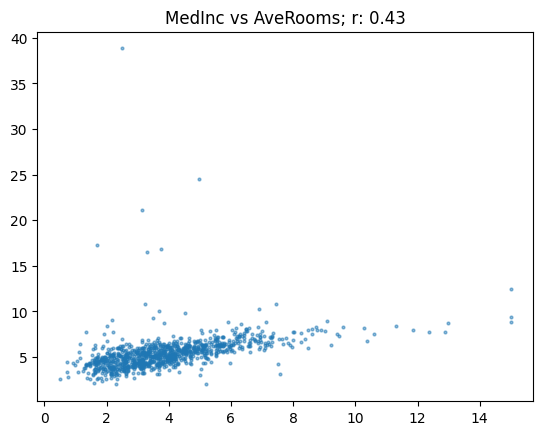

In [34]:
from transformers import Trainer, TrainingArguments

## Training Configuration

Setting up training parameters including batch size, learning rate, and other hyperparameters for fine-tuning the DeBERTa model.

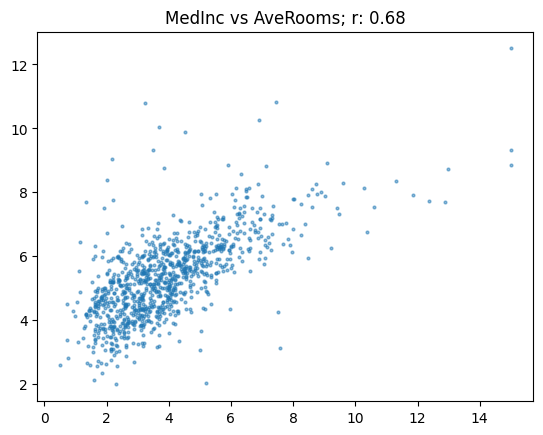

In [35]:
bs = 128
epochs = 4

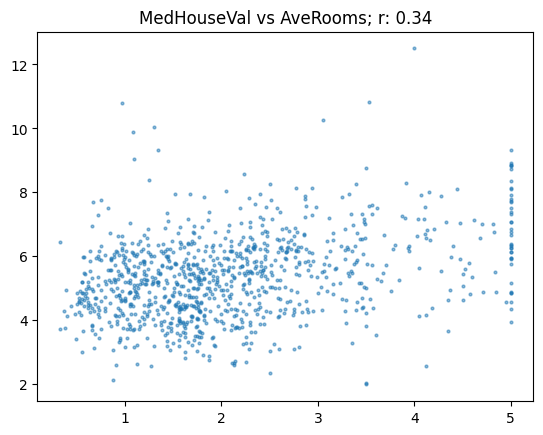

In [36]:
lr = 8e-5

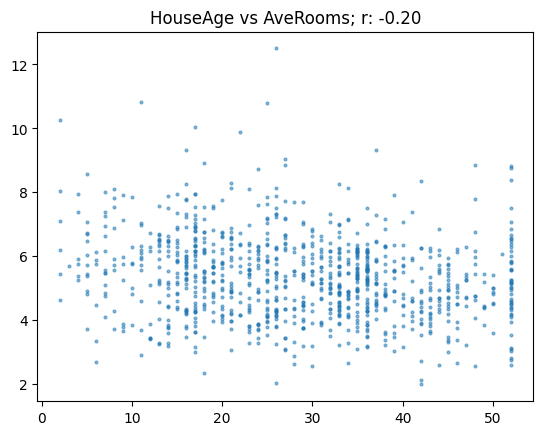

In [37]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [38]:
# %pip install transformers[torch]
# %pip install 'accelerate>=0.26.0'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_14095/3597993663.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
/tmp/ipykernel_14095/3597993663.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],


In [39]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [57]:
eval_df = pd.read_csv(path/'test.csv')
eval_df

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04
5,474c874d0c07bd21,dry corn,dry corn starch,C12
6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11
7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23
8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10
9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02


## Prediction and Submission

Loading test data, generating predictions, and creating a submission file in the required format.

In [77]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor

In [78]:
eval_ds = Dataset.from_pandas(eval_df)

In [79]:
eval_ds = eval_ds.map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [80]:
# Now predict using the properly formatted dataset
preds = trainer.predict(eval_ds).predictions.astype(float)

In [82]:
preds = np.clip(preds, 0, 1)
preds

array([[0.48],
       [0.82],
       [0.34],
       [0.35],
       [0.  ],
       [0.43],
       [0.36],
       [0.05],
       [0.09],
       [1.  ],
       [0.17],
       [0.28],
       [0.67],
       [0.7 ],
       [0.79],
       [0.34],
       [0.22],
       [0.03],
       [0.48],
       [0.25],
       [0.34],
       [0.21],
       [0.08],
       [0.16],
       [0.52],
       [0.  ],
       [0.  ],
       [0.03],
       [0.  ],
       [0.68],
       [0.28],
       [0.04],
       [0.71],
       [0.35],
       [0.35],
       [0.15]])

In [83]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_df['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

862